In [1]:
from itertools import count
import gc
import time
import pandas as pd
import numpy as np

from agent.main import Agent
from emulator.main import Account

from IPython.display import clear_output

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from params import *

# viz = Visdom()
# assert viz.check_connection()

init quotes shape
(26244, 5)
init factors shape
(25976, 28)
init daily shape
(12420, 5)
smp daily shape
(12360, 5)
2014-03-14 11:00:00
smp factors shape
(12420, 28)
DatetimeIndex(['2014-03-11 09:30:00', '2014-03-11 09:45:00',
               '2014-03-11 10:00:00', '2014-03-11 10:15:00',
               '2014-03-11 10:30:00', '2014-03-11 10:45:00',
               '2014-03-11 11:00:00', '2014-03-11 11:15:00',
               '2014-03-11 11:30:00', '2014-03-11 13:00:00',
               '2014-03-11 13:15:00', '2014-03-11 13:30:00',
               '2014-03-11 13:45:00', '2014-03-11 14:00:00',
               '2014-03-11 14:15:00', '2014-03-11 14:30:00',
               '2014-03-11 14:45:00', '2014-03-11 15:00:00',
               '2014-03-12 09:30:00', '2014-03-12 09:45:00',
               '2014-03-12 10:00:00', '2014-03-12 10:15:00',
               '2014-03-12 10:30:00', '2014-03-12 10:45:00',
               '2014-03-12 11:00:00', '2014-03-12 11:15:00',
               '2014-03-12 11:30:00', '201

In [2]:
env = Account()
state = env.reset()
image_shape = state.shape
agent = Agent(image_shape,3)

(12360, 60, 28, 1)
(12360, 60, 28, 1)
(1, 60, 28)
3
(1, 60, 28)
3


In [3]:
def plot_loss(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(30,8))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [4]:
# fill cache
for episode in range(10):
    state = env.reset()
    while True:
        action = agent.get_epsilon_policy(np.expand_dims(state, 0),0)
        next_state, reward, done = env.step(action)
        agent.append(state, action, reward, done, next_state)
        state = next_state
        
        if done:
            break
print(agent.get_cache_len())

62010


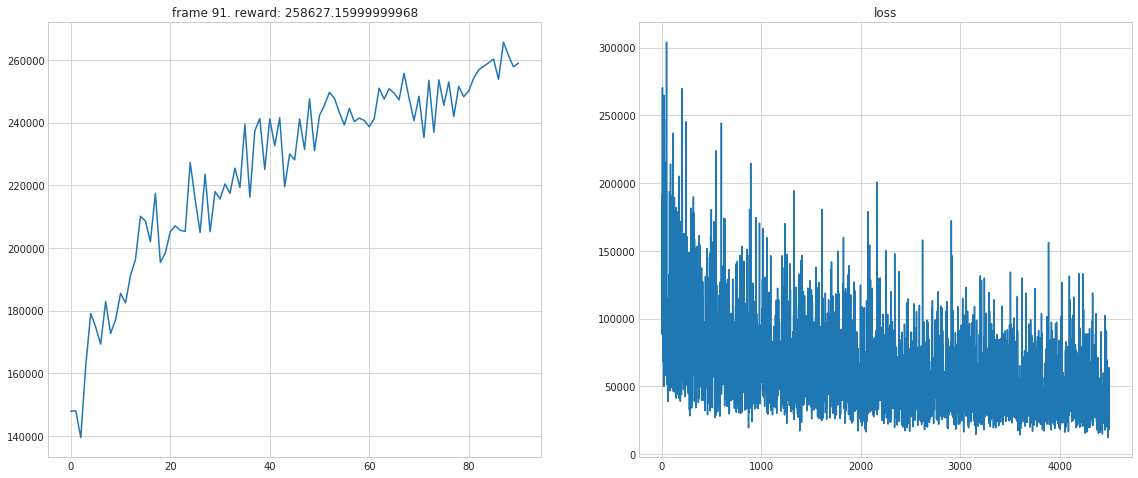

In [ ]:
max_episodes = 150
global_step = 0

episode_reward = 0

episodes_train = []
all_rewards = []
losses = []

all_st = time.clock()

for episode in range(max_episodes):
    state = env.reset()
    episode_step = 0
    cache_reward = []
    cache_value = []
    while True:
        global_step += 1
        episode_step += 1
        
        action = agent.get_epsilon_policy(np.expand_dims(state, 0),EPSILON_VALUE)
        #next_state, reward, done = env.step(action)
        next_state, reward, done = env.step(action,False)
        agent.append(state, action, reward, done, next_state)
        state = next_state

        cache_reward.append(reward)
        cache_value.append(env.total_value)
        episode_reward += reward

        if global_step % TARGET_STEP_SIZE == 0:
            agent._update_target()

        if episode_step % TRAIN_STEP_SIZE == 0 or done:
            loss = agent.optimize()
            losses.append(loss.data[0])

            if done:
                #print(episode, env.total_value)
                all_rewards.append(env.total_value)
                episodes_train.append(env.plot_data())
                gc.collect()
                break
            
        if episode_step % TRAIN_STEP_SIZE == 0:
            plot_loss(episode, all_rewards, losses)
        
        
#tmp = env.plot_data()
#tmp.iloc[:, 0].plot(figsize=(16, 6))

all_ed = time.clock()
print('Total Using Time %s Hours'%((all_ed-all_st)/3600))
agent.save_model()

In [ ]:
episode_value = [i["value"] for i in episodes_train]
episode_value = pd.concat(episode_value, axis=1)
episode_value.columns = list(range(episode_value.shape[1]))
episode_value.plot(figsize=(12, 9))

plt.savefig("样本内.png")

In [ ]:
agent.load_model()
state = env.reset()
for i in range(Full_Size):
    action = agent.get_deterministic_policy(np.expand_dims(state, 0))
    #next_state, reward, done = env.step(action)
    next_state, reward, done = env.step(action,True)
    state = next_state

In [ ]:
tmp = env.plot_data()
tmp.iloc[:, 0].plot(figsize=(16, 6))

In [ ]:
tmp.iloc[Smp_Size:, 0].plot(figsize=(16, 6))
plt.savefig("样本外.png")

In [ ]:
test_data = tmp.iloc[Smp_Size:]
ratio = np.sum(np.maximum(np.sign(test_data['reward']), 0))/test_data.shape[0]
print("胜率:", ratio)